# Title: csck700_bsdd_enrichment

### The bsdd_enrichment Python module queries the buildingSMART Data Dictionary (bSDD) API to retrieve canonical metadata for technical properties and ensures semantic alignment. It creates extended property sets when not present in the IFC database and links new properties to them, or, when property sets already exist, it connects the enriched properties directly to the corresponding IfcPropertySet in the graph.

In [1]:
from IPython.display import Image, display

In [2]:
picture_path = r"..\references\graph_enrichment_layer.jpg"

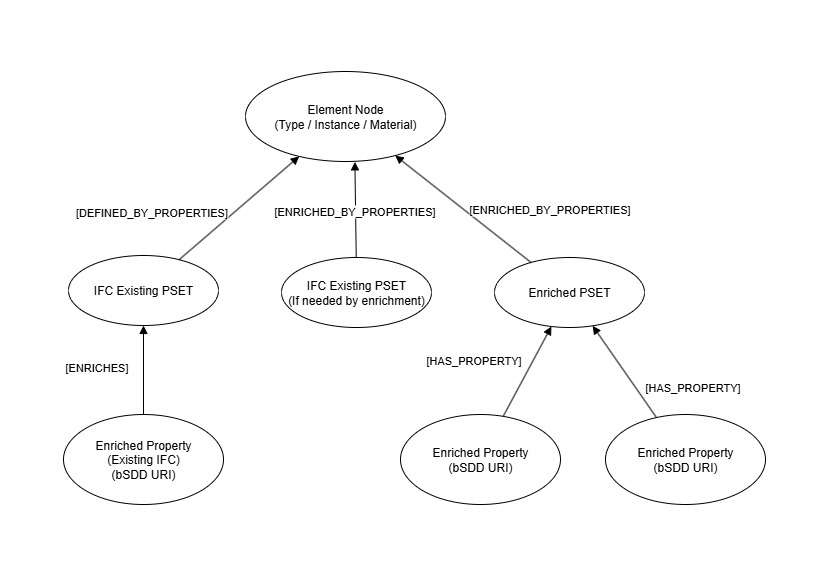

In [3]:
display(Image(filename=picture_path))

# 0. Table of content:

- [1. Settings:](#1.-Settings:)
- [2. Imports:](#2.-Imports:)
- [3. Helper functions:](#3.-Helper-functions:)
- [4. Data load:](#4.-Data-load:)  
- [5. bsDD preparation:](#5.-bsDD-preparation:)
- [6. Graph enrichment:](#6.-Graph-enrichment:)  

# 1. Settings:

# 2. Imports:

In [37]:
# !pip install pandas
import pandas as pd
# !pip install openpyxl
import openpyxl
import warnings
warnings.simplefilter("ignore", UserWarning)
import requests
from requests.adapters import HTTPAdapter, Retry
import time
import re
# !pip install rapidfuzz
from rapidfuzz import fuzz

# 3. Helper functions:

# 4. Data load:

In [5]:
file_path = r"..\data\raw\1111.xlsx"

In [6]:
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
print(sheet_names)

['description', 'data_validation', 'stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe']


In [7]:
df_names = sheet_names[2:]

In [8]:
dfs = dict()
for df_name in df_names:
    dfs[df_name] = pd.read_excel(file_path, sheet_name=df_name)

In [9]:
for name, df in dfs.items():
    print(f"\n### Dataframe: {name} ###")
    display(df.head(10))


### Dataframe: stone_wall_chimney ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,absorption,≤ 7.5 %,≤,7.5,%,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,bulk specific gravity,≥ 2.16 g/cm³,≥,2.16,g/cm³,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,modulus of rupture,≥ 7 MPa,≥,7,MPa,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C99,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MPa,≥,7,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C880,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,weathering classification,= suitable for exterior use,=,suitable for exterior use,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C568 / C616,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,resistance to freezing and thawing,= pass,=,pass,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C666,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,joint thickness,= 6–10 mm,range,6-10,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§3.3,NaN,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,finish,= smooth machine finish free of tool marks; 4-...,enum,"{smooth machine, 4-cut, 6-cut, equivalent, fre...",NaN,Type,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,NaN,NaN,NaN,NaN



### Dataframe: roof_wood_beam ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beam_001,Roof Wood Beam,IfcBeam,species,douglas fir-larch,=,douglas fir-larch,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
1,beam_002,Roof Wood Beam,IfcBeam,grade,No.1,=,No.1,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
2,beam_003,Roof Wood Beam,IfcBeam,moisture content,≤ 19%,≤,19,%,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
3,beam_004,Roof Wood Beam,IfcBeam,fire retardant treatment,Pass,=,Pass,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,ASTM E84,NaN,NaN,NaN
4,beam_005,Roof Wood Beam,IfcBeam,preservative treatment,CCA,=,CCA,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,AWPA U1,NaN,NaN,NaN
5,beam_007,Roof Wood Beam,IfcBeam,straightness tolerance,"Lumber shall be free from bow, crook, twist, a...",enum,"{""bow_mm_per_2.4m"": 6, ""crook_mm_per_2.4m"": 6,...",NaN,Type,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,WWPA / NLGA,NaN,NaN,NaN
6,beam_008,Roof Wood Beam,IfcBeam,bending strength,11.0 Mpa,=,11,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
7,beam_009,Roof Wood Beam,IfcBeam,elastic modulus,"12,400 Mpa",=,12400,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
8,beam_010,Roof Wood Beam,IfcBeam,bearing length,≥ 90 mm,≥,90,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN
9,beam_011,Roof Wood Beam,IfcBeam,spacing (on center),600 mm,=,600,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN



### Dataframe: strip_footing ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,footing_001,Strip Footing,IfcFooting,compressive strength,28 MPa,=,28,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 01,"§2.5.1, §3.14.3.4",ASTM C39,NaN,NaN,NaN
1,footing_002,Strip Footing,IfcFooting,slump,75 ± 25 mm,=,75 ± 25,mm,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.14.3.1,ASTM C143,NaN,NaN,NaN
2,footing_003,Strip Footing,IfcFooting,water cement ratio,0.45,≤,0.45,w/cm,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.5.2.6,"ACI 211.1, ACI 211.2",NaN,NaN,NaN
3,footing_004,Strip Footing,IfcFooting,nominal maximum aggregate size,25 mm,≤,25,mm,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.3.3.1,ASTM C33,NaN,NaN,NaN
4,footing_006,Strip Footing,IfcFooting,rebar grade,grade 60,=,grade 60,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.6.1,ASTM A615,NaN,NaN,NaN
5,footing_007,Strip Footing,IfcFooting,rebar coating,uncoated,=,uncoated,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,"§2.6.1.1, §2.6.1.4",ASTM A615,NaN,NaN,NaN
6,footing_008,Strip Footing,IfcFooting,concrete cover to rebar,≥ 75 mm,≥,75,mm,Type,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.5.12,ACI 318,NaN,NaN,NaN
7,footing_009,Strip Footing,IfcFooting,dimensional tolerances,25 mm,=,25,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.3.8,ACI 117,NaN,NaN,NaN
8,footing_010,Strip Footing,IfcFooting,surface finish,standard smooth finish,=,standard smooth finish,NaN,Type,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.9.3.3,ACI 301,NaN,NaN,NaN



### Dataframe: beam_shoe ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beamshoe_001,Beam Shoe,IfcDiscreteAccessory,base material,stainless steel bars and shapes Type 304,=,Type 304,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.1,ASTM A276/A276M,NaN,NaN,NaN
1,beamshoe_002,Beam Shoe,IfcDiscreteAccessory,corrosion protection,hot-dip galvanize items,=,Z275 (G90),NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.3.1,ASTM A123/A153,NaN,NaN,NaN
2,beamshoe_003,Beam Shoe,IfcDiscreteAccessory,anchor bolts,anchor bolts,=,55,ksi,Type,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.8,ASTM F1554,NaN,NaN,NaN
3,beamshoe_004,Beam Shoe,IfcDiscreteAccessory,dissimilar metal protection,dissimilar metals,=,MPI 79,NaN,Type,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§3.6,ASTM D1187,NaN,NaN,NaN


# 5. bsDD preparation:

## 5.1. Mapping UFGS Technical properties to IFC/bsDD:

#### Introduction to the Mapping Methodology:  

This step establishes correspondences between UFGS technical properties and IFC/bSDD definitions to support semantic enrichment of IFC-based graphs. The approach is semi-automated, combining automated retrieval from the buildingSMART Data Dictionary (bSDD) with manual validation.  

While bSDD provides authoritative URIs, names, and definitions, it does not encode applicability rules linking property sets to specific IfcClass. These rules are instead defined in separate IFC Property Set Definition (PSD) templates. For example, Pset_WallCommon applies to IfcWall and IfcWallType, but this link is absent in the bSDD API.  

Accordingly, this work follows a two-stage process:  

- Automated retrieval using /api/TextSearch/v2 and /api/Property/Classes/v1 to obtain candidate IFC properties, their property sets, and URIs.  

- Manual validation to select the semantically most appropriate property and property set for the target IfcClass.  

This process is used to check whether a UFGS property already exists in the IFC 4.3 dictionary. If a match is found, the corresponding IfcProperty and IfcPropertySet (URI, code, and name) are captured for graph construction. If no equivalent exists in IFC, the search continues in the ETIM dictionary as an alternative source.

### 5.1.1. Properties automated retrieval and manual equivalence selection (IFC 4.3 Dictionary Search):

For each UFGS property, an automated query to the bSDD /api/TextSearch/v2 endpoint (IFC 4.3 dictionary) retrieves candidate IFC property definitions. The user then selects the most appropriate match from the returned candidates, capturing its URI, code, and name.

In [34]:
BASE = "https://api.bsdd.buildingsmart.org"
IFC43 = "https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3"
ETIM = "https://identifier.buildingsmart.org/uri/etim/etim/10.0"
HEADERS = {
    "accept": "application/json",
    "user-agent": "BenoitCapstone/1.0"
}
TIMEOUT = 30

In [18]:
# def _get(path, params):
    
#     r = requests.get(f"{BASE}{path}", params=params, headers=HEADERS, timeout=TIMEOUT)
#     r.raise_for_status()
    
#     return r.json()

In [21]:
df_names

['stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe']

In [38]:
# 1) robust GET helper with retries/backoff
session = requests.Session()
retry = Retry(
    total=5,                   # up to 5 attempts
    backoff_factor=0.6,        # 0.6, 1.2, 2.4, ...
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
session.mount("https://", HTTPAdapter(max_retries=retry))

def _get(path, params, timeout=(5, 30)):  # (connect, read) seconds
    r = session.get(
        f"{BASE}{path}",
        params=params,
        headers={"Accept": "application/json", "Accept-Encoding": "gzip, deflate"},
        timeout=timeout,
    )
    r.raise_for_status()
    return r.json()

In [48]:
def map_ufgs_to_ifc(dfs, df_names, IFC43):
    """
    Map UFGS technical parameters to IFC properties using the bSDD API.

    For each dataframe in `dfs` (identified by `df_names`), this function:
      1. Extracts the list of UFGS parameter names.
      2. Queries the bSDD `/api/TextSearch/v2` endpoint restricted to the IFC 4.3 dictionary
         to retrieve candidate IFC property definitions.
      3. Displays the candidate properties to the user in a numbered list.
      4. Prompts the user to select the best matching IFC property or "None" if not applicable.
      5. Records the selection as a dictionary containing only the IFC property
         `uri`, `code`, and `name`, or `None` if no equivalent was chosen.

    Results are collected in a dictionary with the dataframe name as key and a list of
    selections (one per UFGS parameter) as value.
    """

    ifc_props_dict = dict()
    
    for df_name in df_names:
        df_asset = dfs[df_name]
        # df_class = df_asset.loc[0,"ifc_class"].split(";")[0]
        ufgs_list = list(df_asset["parameter_name_input"])
        print(ufgs_list)
        
        ifc_properties = []
        
        for ufgs in ufgs_list:
        
            data = _get(
            "/api/TextSearch/v2",
            params = {
                "SearchText": ufgs,
                "DictionaryUris": [IFC43],
                "TypeFilter": "Property",
                "IncludeInactive": True,
                "IncludePreview": True
            })
        
            props = data.get("properties", [])
        
            if not props:
                print(f"{ufgs} - No equivalent properties found.")
                selected = None
                ifc_properties.append(selected)
                continue
                
            else:
                print(f"\n{ufgs.upper()} - CANDIDATE IFC PROPERTIES:")
                for i, p in enumerate(props):
                    print(f"[{i}] - {p.get('name')}: ({p.get('description')}).")
                print(f"[{len(props)}] - None / Not applicable.")
        
                while True:
                    try:
                        choice = int(input("Select the index of the best match: "))
                        if 0 <= choice <= len(props):
                            if choice == len(props):
                                selected = None
                            else:
                                hit = props[choice]
                                selected = {
                                    "uri": hit.get("uri"),
                                    "code": hit.get("code"),
                                    "name": hit.get("name")
                                }  
                            ifc_properties.append(selected)
                            break
                        else:
                            print("Invalid choice. Try again.")        
                    except ValueError:
                        print("Please enter a number.")
        
        # print(ifc_properties)
        ifc_props_dict[df_name] = ifc_properties

    return ifc_props_dict

In [49]:
ifc_props_dict = map_ufgs_to_ifc(dfs, df_names, IFC43)

['absorption', 'bulk specific gravity', 'modulus of rupture', 'flexural strength', 'weathering classification', 'resistance to freezing and thawing', 'joint thickness', 'finish']

ABSORPTION - CANDIDATE IFC PROPERTIES:
[0] - Energy Absorption: (Energy absorption capacity of the element.).
[1] - Energy Absorption Tolerance: (Manufacturing tolerance on energy absorption).
[2] - Particle Absorption Curve: (Ratio of particles that are removed by the filter. Each entry describes the ratio of particles absorbed greater than equal to the specified size and less than the next specified size. For example, given for 3 significant particle sizes >= 0,1 micro m, >= 1 micro m, >= 5 micro m).
[3] - Solar Absorption: ((Asol) The ratio of incident solar radiation that is absorbed by a glazing system. It is the sum of the absorption distributed to the exterior (a) and to the interior (qi). Note the following equation Asol + Rsol + Tsol = 1).
[4] - Sound Absorption Limit: (Mandatory limit values in soun

Select the index of the best match:  5


bulk specific gravity - No equivalent properties found.
modulus of rupture - No equivalent properties found.
flexural strength - No equivalent properties found.
weathering classification - No equivalent properties found.
resistance to freezing and thawing - No equivalent properties found.
joint thickness - No equivalent properties found.

FINISH - CANDIDATE IFC PROPERTIES:
[0] - Finish: ([[Description]] of the (surface) finish of the object for informational purposes.).
[1] - Finish Ceiling Height: ([[Height]] of the suspended ceiling (from top of flooring to the bottom of the suspended ceiling). To be provided only if the space has a suspended ceiling with constant height.).
[2] - Finish Colour: (The finish colour of the object.).
[3] - Finish Floor Height: ([[Height]] of the flooring (from base slab without flooring to the flooring height). To be provided only if the space has a constant flooring height.).
[4] - Finish Time: (The finish time of the schedule.).
[5] - Finish Type: (The

Select the index of the best match:  0


['species', 'grade', 'moisture content', 'fire retardant treatment', 'preservative treatment', 'straightness tolerance', 'bending strength', 'elastic modulus', 'bearing length', 'spacing (on center)']

SPECIES - CANDIDATE IFC PROPERTIES:
[0] - Species: (Wood species of a solid wood or laminated wood product.).
[1] - None / Not applicable.


Select the index of the best match:  0



GRADE - CANDIDATE IFC PROPERTIES:
[0] - Operation Type: ([[Type]] of operations. Also used to assign standard symbolic presentations according to national building standards.).
[1] - Accuracy Grade: (The grade of accuracy.).
[2] - Appearance Grade: (Grade with respect to visual quality.).
[3] - Berth Grade: (Berth grade).
[4] - Lock Grade: (Operational grading of the ship lock complex).
[5] - Steel Grade: (Deprecated.).
[6] - Strength Grade: (Grade with respect to mechanical strength and stiffness.).
[7] - Structural Grade: (Classification label to define mechanical properties according to structural grades defined in published standards; designated by numbers, letters, or a combination of both.).
[8] - None / Not applicable.


Select the index of the best match:  7



MOISTURE CONTENT - CANDIDATE IFC PROPERTIES:
[0] - Moisture Content: (Total weight of moisture relative to oven-dried weight of the wood.).
[1] - None / Not applicable.


Select the index of the best match:  0


fire retardant treatment - No equivalent properties found.
preservative treatment - No equivalent properties found.
straightness tolerance - No equivalent properties found.

BENDING STRENGTH - CANDIDATE IFC PROPERTIES:
[0] - Bending Strength: (Bending strength.).
[1] - None / Not applicable.


Select the index of the best match:  0


elastic modulus - No equivalent properties found.
bearing length - No equivalent properties found.
spacing (on center) - No equivalent properties found.
['compressive strength', 'slump', 'water cement ratio', 'nominal maximum aggregate size', 'rebar grade', 'rebar coating', 'concrete cover to rebar', 'dimensional tolerances', 'surface finish']

COMPRESSIVE STRENGTH - CANDIDATE IFC PROPERTIES:
[0] - Compressive Strength: (The compressive strength of the object or material.).
[1] - Raised Compressive Strength: (Alternative value for compressive strength which may be used under material and code dependent conditions (e.g. if deformation is tolerable, or far from ends of the member); conditions should be stated in IfcProperty.[[Description]].).
[2] - None / Not applicable.


Select the index of the best match:  0


slump - No equivalent properties found.
water cement ratio - No equivalent properties found.
nominal maximum aggregate size - No equivalent properties found.
rebar grade - No equivalent properties found.
rebar coating - No equivalent properties found.
concrete cover to rebar - No equivalent properties found.
dimensional tolerances - No equivalent properties found.
surface finish - No equivalent properties found.
['base material', 'corrosion protection', 'anchor bolts', 'dissimilar metal protection']

BASE MATERIAL - CANDIDATE IFC PROPERTIES:
[0] - Base Material: (The material from which the base of the chamber is constructed.;).
[1] - None / Not applicable.


Select the index of the best match:  1


corrosion protection - No equivalent properties found.
anchor bolts - No equivalent properties found.
dissimilar metal protection - No equivalent properties found.


In [50]:
ifc_props_dict.keys()

dict_keys(['stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe'])

In [51]:
print(ifc_props_dict)

{'stone_wall_chimney': [None, None, None, None, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Finish', 'code': 'Finish', 'name': 'Finish'}], 'roof_wood_beam': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Species', 'code': 'Species', 'name': 'Species'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/StructuralGrade', 'code': 'StructuralGrade', 'name': 'Structural Grade'}, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/MoistureContent', 'code': 'MoistureContent', 'name': 'Moisture Content'}, None, None, None, {'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/BendingStrength', 'code': 'BendingStrength', 'name': 'Bending Strength'}, None, None, None], 'strip_footing': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength', 'code': 'CompressiveStrength', 'name': 'Compressive Streng

### 5.1.2. Property set identification:

Automated query using /api/Property/Classes/v1 to list candidate IFC Property Sets that may contain the selected property.

In [ ]:
cls = _get(
    "/api/Property/Classes/v1",
    params = {
        "PropertyUri": 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength'
    })
cls
# items = cls.get("propertyClasses", [])
# codes = {i.get("uri", "").rsplit("/")[-1]for i in items}
# codes

### 5.1.3. Property set manual selection:

Validation and selection of the most contextually appropriate Property Set (URI, code, name), considering the asset’s IfcClass.

### 5.1.4. Information capture for grpah construction:

Final documentation step: store definitive URIs, codes, and names for both the IFC Property and the selected Property Set, enabling consistent population of graph nodes.

## 5.2. Property resolution logic:

## 5.3. Load authoring sheet:

## 5.4. Fill bsDD columns:

# 6. Graph enrichment:

## 6.1. Compile targets from graph:

## 6.2. Cypher generation:

## 6.3. Sanity check:

# 7. Data save: